Project: DataSc_predict_explain_diabetes       -       Creator: Benjamin Gaube       -        Date: 2024-07-14

# Build a Classifieer to predict diabetes and evaluate Features via shap-values
<br> 
<b>Source: </b>https://www.kaggle.com/datasets/nanditapore/healthcare-diabetes/
<br>
<b>Preliminary considerations: </b> I decided based on the analisys in 01_analyze_data.ipynb do drop the feature pregnancies. Also I further differenciated with a deterministic rule the target into healthy, diabetes type I and diabetes type II.
<br>
<b>Purpose: </b> Creation of a gender-neutral classifier for healthy individuals, type I and type II diabetics. In addition, evaluation of the relevance of the features (using shap-values) in order to differentiate between these diseases without insulin use.
<br>
<b>Classifier: </b>Since I lost a lot of data in the cleaning process, a neural network would be inappropriate. With three targets, I cannot use binary classifiers such as logistic regression. A obvious solution would be a simple decision tree. But with seven features, an ensemble method is more appropriate. Since I have no categorical features, I don't need to consider LightGBM or CutBoost and will opt for a normal random forest.

## Librarys and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
# as finaly decided in 01_analyze_data.ipynb

df = pd.read_csv(r'..\..\data\Healthcare_Diabetes_Dataset\Healthcare-Diabetes.csv')
df = df.query('Glucose != 0 and BloodPressure != 0 and SkinThickness != 0 and BMI != 0')
df = df.drop_duplicates(subset=df.columns.difference(['Id']), keep='first')
df = df.drop(columns=['Pregnancies'])
df.loc[:,'Outcome_dif'] = np.select([(df['Outcome'] == 1) & (df['Insulin'] > 20), (df['Outcome'] == 1) & (df['Insulin'] <= 20)], ['type_II', 'type_I'], default='healthy')

## Random Forest including Insulin as feature
Since I used insulin to deterministically categorize healthy, type 1 diabetes and type 2 diabetes, it would not be surprising that a classifier would "find" this rule, even though there are also individuals with high insulin in the data set who are labeled as healthy based on the original outcom-variable.

### train the mopdel (with insulin)

In [3]:
# split the features (X) and targets (y) int to differentiated by Target ((healhty, typ_I, type_II) )
# reason: get an equal 80:20 split across all subsets (healhty, typ_I, type_II) 

X_healthy = df[df['Outcome_dif'] == 'healthy'].drop(['Outcome', 'Id', 'Outcome_dif'], axis=1)
y_healthy = df[df['Outcome_dif'] == 'healthy']['Outcome_dif']
X_type_I = df[df['Outcome_dif'] == 'type_I'].drop(['Outcome', 'Id', 'Outcome_dif'], axis=1)
y_type_I = df[df['Outcome_dif'] == 'type_I']['Outcome_dif']
X_type_II = df[df['Outcome_dif'] == 'type_II'].drop(['Outcome', 'Id', 'Outcome_dif'], axis=1)
y_type_II = df[df['Outcome_dif'] == 'type_II']['Outcome_dif']

In [4]:
# split each of the subsets (healhty, typ_I, type_II) into test and traingings data
X_train_healthy, X_test_healthy, y_train_healthy, y_test_healthy = train_test_split(X_healthy, y_healthy, test_size=0.2, random_state=123)
X_train_type_I, X_test_type_I, y_train_type_I, y_test_type_I = train_test_split(X_type_I, y_type_I, test_size=0.2, random_state=123)
X_train_type_II, X_test_type_II, y_train_type_II, y_test_type_II = train_test_split(X_type_II, y_type_II, test_size=0.2, random_state=123)

# concatenate subsets (healhty, typ_I, type_II) of the trainings- and testdate
X_train = pd.concat([X_train_healthy, X_train_type_I, X_train_type_II])
X_test = pd.concat([X_test_healthy, X_test_type_I, X_test_type_II])
y_train = pd.concat([y_train_healthy, y_train_type_I, y_train_type_II])
y_test = pd.concat([y_test_healthy, y_test_type_I, y_test_type_II])

In [5]:
#Initialize and train random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=123)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

### evaluate the model (with insulin) quality

In [6]:
# prediction
y_pred = rf_model.predict(X_test)

# model evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     healthy       0.81      0.83      0.82        72
      type_I       0.58      0.70      0.64        10
     type_II       0.70      0.59      0.64        27

    accuracy                           0.76       109
   macro avg       0.70      0.71      0.70       109
weighted avg       0.76      0.76      0.76       109



The overall accuracy of the model is 0.76, indicating that 76% of the predictions were correct.

<b>Healthy: </b>The model identifies healthy cases with a precision of 0.81 and a recall of 0.83. The F1-score of 0.82 shows a good balance between precision and recall. <br>

<b>Type_I: </b>The model struggles to recognize type_I cases, as indicated by the lower F1-score of 0.64. Given the small number of cases for type_I diabetes in the dataset, this result is acceptable. However, future analyses with larger datasets are necessary to improve the model's performance.<br>

<b>Type_II: </b>The model identifies type_II cases with a precision of 0.70 and a recall of 0.59. The F1-score of 0.64 is similar to that of type_I, indicating similar performance challenges.<br>

In summary, while the model performs reasonably well for healthy cases, it has difficulty accurately identifying both type_I and type_II diabetes cases. Taking into account that there were few data points available, pregnancies were not used as a feature, and the classifier was not optimized through feature transformation and hyperparameter tuning, the results are satisfactory.

Nevertheless, this highlights the need for larger datasets in future examinations to enhance the model's ability to distinguish between different types of diabetes effectively without considering pregnancies or other gender-specific variables

###  evaluate feature importance of the model (with insulin)

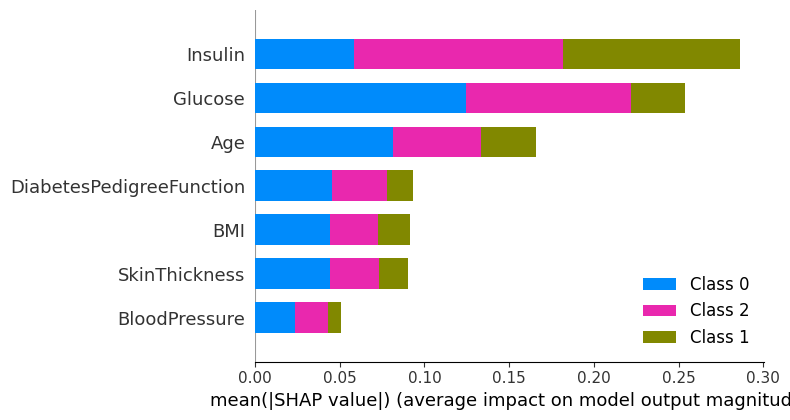

In [7]:
# SHAP Werte berechnen
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.show()

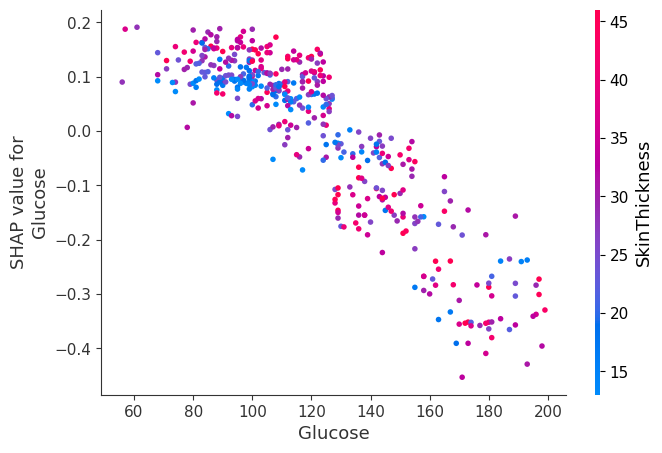

In [8]:
# Dependence Plot (für ein ausgewähltes Feature, z.B. 'Glucose')
shap.dependence_plot("Glucose", shap_values[0], X_train)
plt.show()

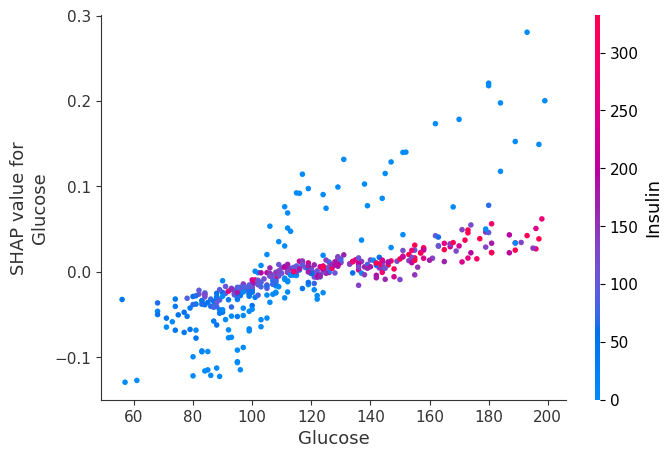

In [9]:
shap.dependence_plot("Glucose", shap_values[1], X_train)
plt.show()

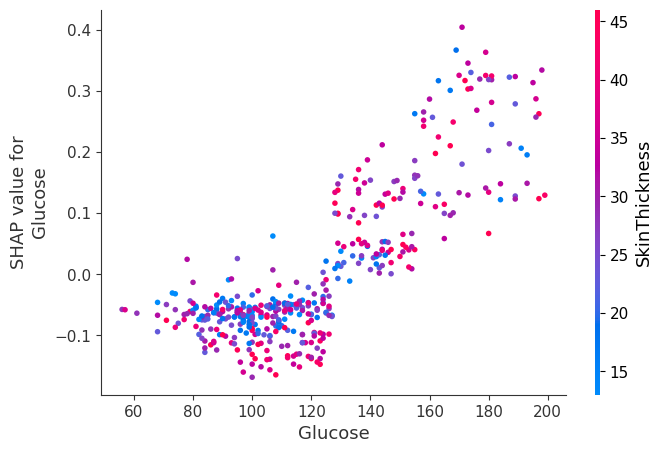

In [10]:
shap.dependence_plot("Glucose", shap_values[2], X_train)

In [11]:
# TODO interpret

## Random Forest without Insulin as a the feature

In [12]:
X_train_no_insulin = X_train.drop('Insulin', axis = 1)
X_test_no_insulin = X_test.drop('Insulin', axis = 1)

rf_model_no_insulin = RandomForestClassifier(n_estimators=100, random_state=123)
rf_model_no_insulin.fit(X_train_no_insulin, y_train)

y_pred_no_insulin = rf_model_no_insulin.predict(X_test_no_insulin)
print(classification_report(y_test, y_pred_no_insulin))

              precision    recall  f1-score   support

     healthy       0.81      0.83      0.82        72
      type_I       0.00      0.00      0.00        10
     type_II       0.43      0.56      0.48        27

    accuracy                           0.69       109
   macro avg       0.41      0.46      0.44       109
weighted avg       0.64      0.69      0.66       109



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


The overall accuracy of the model is 0.69, indicating that 69% of predictions were correct. However, it's important to note that this accuracy is primarily driven by the model's ability to classify healthy individuals accurately and to some extent, Type II diabetes cases. The performance for Type I diabetes is notably poor due to the small number of instances available in the dataset, resulting in the model struggling to make accurate predictions in this category.

<b>healthy: </b>The model identifies healthy cases with a precision of 0.81 and a recall of 0.83. The F1-score of 0.82 demonstrates a balanced performance between precision and recall.

<b>type_I: </b>The model struggles significantly with Type I diabetes cases, achieving a precision and recall of 0.00, resulting in an F1-score of 0.00. Given the limited number of instances for Type I diabetes in the dataset, this outcome is understandable. However, future analyses with larger datasets are essential to enhance the model's capability in this are

<b>Type II: </b>The model identifies Type II diabetes cases with a precision of 0.43 and a recall of 0.56. The F1-score of 0.48 indicates moderate performance in distinguishing Type II diabetes cases.


Summay: Without the information on insulin levels, the model struggles to distinguish Type I diabetes cases from Type II diabetes cases, which is plausible given the distinct metabolic mechanisms.

It is still conceivable that models based on the given features, such as Glucose and DiabetesPedigreeFunction, can differentiate between healthy individuals and diabetics. It is also conceivable that Type 1 diabetics can be distinguished from Type 2 diabetics based on the given features SkinThickness, BloodPressure, and BMI, since Type 2 diabetes is associated with metabolic syndrome unlike Type 1 diabetes. It is conceivable that models based on larger datasets would perform significantly better here.

Due to the insufficient model quality at this point, an evaluation of feature relevance is omitted, and instead, a classifier will be trained specifically to differentiate between Type I and Type II diabetes.

## Drop healthy individuals so that the model only has to distinguish between Type 1 and Type 2 diabetes.

In [28]:
# repeat procedure for a diabetic sample

df_reduced = pd.read_csv(r'..\..\data\Healthcare_Diabetes_Dataset\Healthcare-Diabetes.csv')
df_reduced = df_reduced.query('Glucose != 0 and BloodPressure != 0 and SkinThickness != 0 and BMI != 0')
df_reduced = df_reduced.drop_duplicates(subset=df_reduced.columns.difference(['Id']), keep='first')
df_reduced.loc[:,'Outcome_dif'] = np.select([(df_reduced['Outcome'] == 1) & (df_reduced['Insulin'] > 20), (df_reduced['Outcome'] == 1) & (df_reduced['Insulin'] <= 20)], ['type_II', 'type_I'], default='healthy')


df_reduced = df_reduced.query('Outcome == 1')

X_type_I_reduced = df_reduced[df_diabetes['Outcome_dif'] == 'type_I'].drop(['Outcome', 'Id', 'Outcome_dif'], axis=1)
y_type_I_reduced = df_reduced[df_diabetes['Outcome_dif'] == 'type_I']['Outcome_dif']
X_type_II_reduced = df_reduced[df_diabetes['Outcome_dif'] == 'type_II'].drop(['Outcome', 'Id', 'Outcome_dif'], axis=1)
y_type_II_reduced = df_reduced[df_diabetes['Outcome_dif'] == 'type_II']['Outcome_dif']

X_train_type_I_reduced, X_test_type_I_reduced, y_train_type_I_reduced, y_test_type_I_reduced = train_test_split(X_type_I_reduced, y_type_I_reduced, test_size=0.2, random_state=123)
X_train_type_II_reduced, X_test_type_II_reduced, y_train_type_II_reduced, y_test_type_II_reduced = train_test_split(X_type_II_reduced, y_type_II_reduced, test_size=0.2, random_state=123)

X_train_reduced = pd.concat([X_train_type_I_reduced, X_train_type_II_reduced])
X_train_reduced_no_preg_ins = X_train_reduced.drop('Pregnancies', axis=1).drop('Insulin', axis = 1)
X_train_reduced_no_ins = X_train_reduced.drop('Insulin', axis = 1)
X_test_reduced = pd.concat([X_test_type_I_reduced, X_test_type_II_reduced])
X_test_reduced_no_preg_ins = X_test_reduced.drop('Pregnancies', axis=1).drop('Insulin', axis = 1)
X_test_reduced_no_ins = X_test_reduced.drop('Insulin', axis = 1)
y_train_reduced = pd.concat([y_train_type_I_reduced, y_train_type_II_reduced])
y_test_reduced = pd.concat([y_test_type_I_reduced, y_test_type_II_reduced])

In [29]:
# forcast without insulin and without pregnancies

rf_model_reduced_no_preg_ins = RandomForestClassifier(n_estimators=100, random_state=123)
rf_model_reduced_no_preg_ins.fit(X_train_reduced_no_preg_ins, y_train_reduced)

y_pred_reduced = rf_model_reduced_no_preg_ins.predict(X_test_reduced_no_preg_ins)
print(classification_report(y_test_reduced, y_pred_reduced))

              precision    recall  f1-score   support

      type_I       0.33      0.10      0.15        10
     type_II       0.74      0.93      0.82        27

    accuracy                           0.70        37
   macro avg       0.53      0.51      0.49        37
weighted avg       0.63      0.70      0.64        37



In [30]:
#forcast without insulin and with pregnancies

rf_model_reduced_no_ins = RandomForestClassifier(n_estimators=100, random_state=123)
rf_model_reduced_no_ins.fit(X_train_reduced_no_ins, y_train_reduced)

y_pred_reduced = rf_model_reduced_no_ins.predict(X_test_reduced_no_ins)
print(classification_report(y_test_reduced, y_pred_reduced))

              precision    recall  f1-score   support

      type_I       0.00      0.00      0.00        10
     type_II       0.72      0.96      0.83        27

    accuracy                           0.70        37
   macro avg       0.36      0.48      0.41        37
weighted avg       0.53      0.70      0.60        37



In [ ]:
# todo state that the forcastes far from "good" or something like that